# Kaggle Titanic project <font color=blue><i> (Work in progress) </i></font>

In this project we explore data from the [“Titanic - Machine Learning from Disaster” Kaggle competition](https://www.kaggle.com/c/titanic/overview/description) and train a few simple machine-learning models to predict whether a passenger has survived.

## Introduction

The RMS Titanic was a passenger liner completed on 2 April 1912 and operated by the Oceanic Steam Navigation Company (better known as the White Star Line), a British shipping company founded in 1845 and defunkt in 1934. 
It started its maiden voyage on 10 April 1912 from Southampton to New York, with an estimated 1,317 passengers and 885 crew members aboard. 
Unfortunately, it never reached its destination. 
On 14 April 1912 at 11:40pm, the Titanic collided with an iceberg about 600km south of Newfoundland, opening five of her sixteen watertight compartments to the sea. 
In the early hours of 15 April, the liner sank, causing the death of more than two thirds of those aboard, in part because there were too few lifeboats. 

Whether a particular passenger or crew member survived can, of course, not be fully predicted from information known before the collision. 
However, several factors made survival more or less likely. 
For instance, a “women and children first” policy was (at least partially) enforced, wherefrom adult women and children were given priority access to the lifeboats. 
In this project, we build a simple machine-learning model designed to learn these factors and predict whether a particular passenger or crew member has survived from prior information. 

Obviously, the interest of such a model does not lie in its predictions: the names of those who survived or died in the accident are already known for most of them; and it is unlikely that any algorithm could be more precise than official records, should they contain errors, if working only on prior information. 
Instead, we see it as an exercise to show how to train simple machine-learning models. 
The workflow we lay out here could then be applied to other problems for which no such records exist. 

Before starting with the data exploration, let us load the modules that we will use: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from copy import deepcopy

## Data exploration

Let us first load the train data and print five lines chosen randomly:

In [2]:
name_data_file = '../Data/Kaggle_Titanic/train.csv'
data = pd.read_csv(name_data_file)
data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
698,699,0,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
743,744,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,NaN,S


The dataframe has 12 columns: 

* `PassengerId`, an identification number (equal to the line number in the dataframe indexed from 1), 
* `Survived`, a number equal to 1 if the passenger survived and 0 if it did not,
* `Pclass`, the class (1 for first, 2 for second, and 3 for third),
* `Name`, the full name of the passenger, 
* `sex`, the gender,
* `Age`, the age,
* `SibSp`, the number of siblings and spouses on the ship,
* `Parch`, the number of parents or children on the ship,
* `Ticket`, presumably the ticket number,
* `Fare`, the cost of the ticket,
* `Cabin`, presumably the cabin number,
* `Embarked`, whether the passenger embarked at Southhampton, Cherbourg, or Queenstown (now Cobh).

Let us print a summary of the data set:

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


We first notice that most of the entries for the `Cabin` column are missing. 
There are also 177 missing entries in the `Age` column and 2 in the `Embarked` column.

### The `Survived` column

Let us first check that the `Survived` column contains only two different values:

In [4]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

This is indeed the case. 
We also find it has significantly more 0s than 1s, which was expected as we know that less than half of passengers survived. 

### The `Pclass` column

Let us see which values are in this column:

In [5]:
data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

It contains three values, as expected. 
We notice that more than half of the passengers were in third class. 
Interestingly, more passengers represented in the dataset were in first class than in second class.

### The `Sex` column

Let us do the same for the gender:

In [6]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

As expected (as other gender identities were not reckognized in the UK and USA at the time), two genders are represented: male and female. 
We notice there are significantly more men than women.

### The `Age` column

Let us show some information about the `Age` column:

In [7]:
column = data['Age']
quantity = 'age'
print('Minimum {}: {}'.format(quantity, column.min()))
print('Maximum {}: {}'.format(quantity, column.max()))
print('Mean {}: {}'.format(quantity, column.mean()))
print('Median {}: {}'.format(quantity, column.median()))

Minimum age: 0.42
Maximum age: 80.0
Mean age: 29.69911764705882
Median age: 28.0


The dataset contains information on people from 5 months old (about 0.42 years) to 80 years old. 
The median age is 28 and the average is close to 30. 

Let us show a histogram to have a better idea of the age distribution:

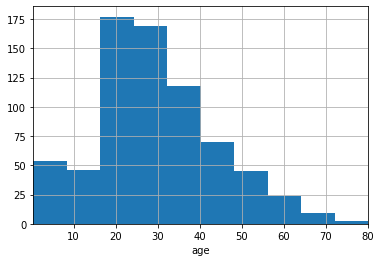

In [8]:
column.hist()
plt.xlabel(quantity)
plt.xlim(column.min(), column.max())
plt.show()

The age distribution shows a peak between the high 10s and the low 30s.

### The `SibSp` and `Parch` columns

In [9]:
print(data['SibSp'].value_counts())
print(data['Parch'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


Most passengenrs had no sibling, spouse, parent, nor children on the ship, and only few of them had more than 2.

### The `Fare` column

Let us show some information about the `Fare` column:

In [10]:
column = data['Fare']
quantity = 'fare'
print('Minimum {}: {}'.format(quantity, column.min()))
print('Maximum {}: {}'.format(quantity, column.max()))
print('Mean {}: {}'.format(quantity, column.mean()))
print('Median {}: {}'.format(quantity, column.median()))

Minimum fare: 0.0
Maximum fare: 512.3292
Mean fare: 32.204207968574636
Median fare: 14.4542


The maximum fare is significantly higher than the mean, which is itself higher than the median, indicating a trongly right-skewed distribution. 

Let us check this by plotting the histogram:

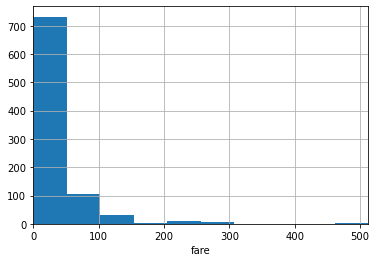

In [11]:
column.hist()
plt.xlabel(quantity)
plt.xlim(column.min(), column.max())
plt.show()

It seems there were a few very expensive tickets. 
Let us re-plot the histogram after discarding them:

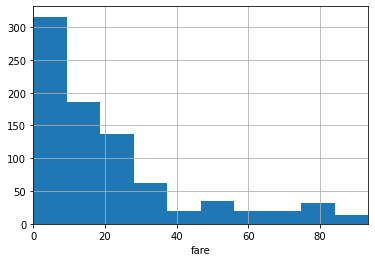

In [12]:
threshold = 100
column_b = column[column < threshold]
column_b.hist()
plt.xlabel(quantity)
plt.xlim(column_b.min(), column_b.max())
plt.show()

There seems to be many relatively cheap tickets and a limited number of much more expensive ones. 

The lowest fare is 0, indicated there were some free tickets, possibly invitations. 
Let us see how many of them there were: 

In [13]:
column[column == 0].count()

15

There were 15 free tickets. 
Let us print the corresponding lines:

In [14]:
data[data['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


These tickets were all given to males embarking at Southhampton, whom had no sibling, spouse, parent, nor children on the chip. 
Only one of them survived.

### The `Embarked` column

Finally, let us count the values in the `Embarked` column:

In [15]:
print(data['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


Most passengers embarked at Southampton. 

### Correlations

Let us not plot the correlation map between all numerical quantities:

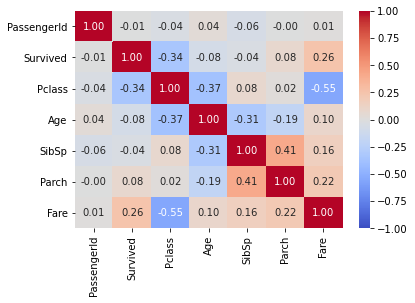

In [16]:
sns.heatmap(data.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

There is a significant negative correlation between the `Pclass` and `Fare` columns. 
This was expected, as first-class tickets tend to be more expensive than second-class ones, which themselves are more expensive than third-class ones. 
There is also a significant positive correlation between the `SibSp` and `Parch` columns and a negative correlation between `Pclass` and `Age` and between `SibSp` and `Age`.

## Data cleaning and feature engineering

In most real-world problems, data cleaning (ensuring the data is as close to beigng correct as possible and has no missing values) and feature engineering (selecting or building the features the model will use) are two separate and importan tasks. 
However, since the dataset we use is already quite ‘clean’, and since most relevant features are already present in the dataset, we will not clearly distinguish these two steps here, and perform them somewhat simultaneously.

### The `Cabin` column

Since most of the entries from this column are missing, and since the cabin number does not give any obvious information which could be correlated with the probability of survival, we will discard this column. 
We define the function `delete_cabin` performing this operation, to be sure it will be done in the same way on the training and test data.

In [17]:
def delete_cabin(df):
    return df.drop('Cabin', 1)

Let us apply it to `data`:

In [18]:
data = delete_cabin(data)
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### The `Age` column

Let us print the lines for which the age is missing:

In [19]:
data[data['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,S


There does not seem to be any obvious pattern. 
We can't discard the `Age` column as the ‘women and children first’ policy may well mak the age an important factor in predicting whether a passenger has survived. 
Instead, we propose to fill the missing value with an average. 
To be more granular, we will divide the passengers into different categories according to their title and the class they traveled in. 

Let us first create the `Title` column:

In [20]:
def create_title(df):
    df['Title'] = df['Name'].str.extract('([a-zA-Z]+\.)')

create_title(data)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr.


We now build a dictionary of averages (the same dictionary will be used for the training and test data):

In [21]:
avg_age_Pclass_Title = {
    (Pclass,Title): 
        data[(data['Pclass']==Pclass) & (data['Title']==Title)]['Age'].mean() 
        for Pclass in data['Pclass'].unique()
        for Title in data['Title'].unique()}

avg_age_Pclass_Title

{(3, 'Mr.'): 28.724890829694324,
 (3, 'Mrs.'): 33.515151515151516,
 (3, 'Miss.'): 16.1231884057971,
 (3, 'Master.'): 5.350833333333334,
 (3, 'Don.'): nan,
 (3, 'Rev.'): nan,
 (3, 'Dr.'): nan,
 (3, 'Mme.'): nan,
 (3, 'Ms.'): nan,
 (3, 'Major.'): nan,
 (3, 'Lady.'): nan,
 (3, 'Sir.'): nan,
 (3, 'Mlle.'): nan,
 (3, 'Col.'): nan,
 (3, 'Capt.'): nan,
 (3, 'Countess.'): nan,
 (3, 'Jonkheer.'): nan,
 (1, 'Mr.'): 41.58045977011494,
 (1, 'Mrs.'): 40.88235294117647,
 (1, 'Miss.'): 30.0,
 (1, 'Master.'): 5.306666666666667,
 (1, 'Don.'): 40.0,
 (1, 'Rev.'): nan,
 (1, 'Dr.'): 43.75,
 (1, 'Mme.'): 24.0,
 (1, 'Ms.'): nan,
 (1, 'Major.'): 48.5,
 (1, 'Lady.'): 48.0,
 (1, 'Sir.'): 49.0,
 (1, 'Mlle.'): 24.0,
 (1, 'Col.'): 58.0,
 (1, 'Capt.'): 70.0,
 (1, 'Countess.'): 33.0,
 (1, 'Jonkheer.'): 38.0,
 (2, 'Mr.'): 32.76829268292683,
 (2, 'Mrs.'): 33.68292682926829,
 (2, 'Miss.'): 22.390625,
 (2, 'Master.'): 2.2588888888888885,
 (2, 'Don.'): nan,
 (2, 'Rev.'): 43.166666666666664,
 (2, 'Dr.'): 38.5,
 (2, 'Mme.

We still have some NaN values. 
Let us thus also make a dictionary of average ages based on the title only:

In [22]:
avg_age_Title = {
    Title: 
        data[(data['Title']==Title)]['Age'].mean() 
        for Title in data['Title'].unique()}

avg_age_Title

{'Mr.': 32.368090452261306,
 'Mrs.': 35.898148148148145,
 'Miss.': 21.773972602739725,
 'Master.': 4.574166666666667,
 'Don.': 40.0,
 'Rev.': 43.166666666666664,
 'Dr.': 42.0,
 'Mme.': 24.0,
 'Ms.': 28.0,
 'Major.': 48.5,
 'Lady.': 48.0,
 'Sir.': 49.0,
 'Mlle.': 24.0,
 'Col.': 58.0,
 'Capt.': 70.0,
 'Countess.': 33.0,
 'Jonkheer.': 38.0}

We also define a dictionary using only the `Pclass` column, in case a passenger's title is not included in the training data.

In [23]:
avg_age_Pclass = {
    Pclass: 
        data[(data['Pclass']==Pclass)]['Age'].mean() 
        for Pclass in data['Pclass'].unique()}

avg_age_Pclass

{3: 25.14061971830986, 1: 38.233440860215055, 2: 29.87763005780347}

We now define the function `fill_age` filling the missing values in the `Age` column, then subtractning its mean and dividing by its standard deviation:

In [24]:
mean_age = data['Age'].mean()
std_age = data['Age'].std()

def fill_age_row(row):
    if not np.isnan(row['Age']):
        return row['Age']
    Pclass = row['Pclass']
    Title = row['Title']
    if (Pclass,Title) in avg_age_Pclass_Title:
        avg1 = avg_age_Pclass_Title[(Pclass,Title)]
        if np.isnan(avg1):
            return avg_age_Title[Title]
        return avg1
    if Title in avg_age_Title:
        return avg_age_Title[Title]
    else:
        return avg_age_Pclass[Pclass]

def fill_age(df):
    df['Age'] = df.apply(fill_age_row, axis=1)
    df['Age'] -= mean_age
    df['Age'] /= std_age
    
fill_age(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### The `Embarked` column

This column has only a few missing values, which we will fill with the most common one, *i.e.*, `S`.

In [25]:
def fill_Embarked(df):
    df['Embarked'] = df['Embarked'].fillna('S')

fill_Embarked(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Discarding the irrelevant columns

We choose to discard: 
* the Passenger ID, since it seems to have been assigned arbitrarily,
* the Name, as it is unlikely to have an impact on survival chances (apart, maybe, from the title),
* the `Ticket` and `Fare` columns, as the relevent information they convey are probably already included in `Pclass`.

Some comments: 
* The columns `Title` and `Sex` give overlapping information. However, some titles apply to both genders (for instance, there are one female doctor and several male ones in the dataset), and each gender can have several titles. We would thus lose information by discarding one of them.
* There is also some overlap between the `Age` and `Title` columns; however, the first one is more precise and the second one can take different values for a given age. So, again, discarding one of them would induce some loss of information.
* One may wonder wether keeping the `Age` column is relevant given that the title already gives an indication about the age. However, some titles, for instance `Miss`, can apply to adults as well as children. Moreover, even a title used only for adults may not differentiate between a young adult and an elderly, which may affect the survival chance.
* One could argue that the title is not relevant, or that most of the information it conveys is already included in the gender and age. However, it could still hold some marginally relevant information on a person's background (for instance, if it indicates military training).

In [26]:
def drop_columns(df):
    return df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Title'], 1)

data = drop_columns(data)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,-0.530005,1,0,S
1,1,1,female,0.571430,1,0,C
2,1,3,female,-0.254646,0,0,S
3,1,1,female,0.364911,1,0,S
4,0,3,male,0.364911,0,0,S


### One-hot encoder

Let us define a one-hot encoder for the categorical data:

In [27]:
cat_columns = ['Sex','Embarked']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(data[cat_columns])

def to_cat(df):
    one_hot_cols = pd.DataFrame(ohe.transform(df[cat_columns]), columns=ohe.get_feature_names())
    df = df.drop(cat_columns, axis=1)
    df = pd.concat([df, one_hot_cols], axis=1)
    df = df.drop(['x0_male'], axis=1)
    return df

data = to_cat(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,x0_female,x1_C,x1_Q,x1_S
0,0,3,-0.530005,1,0,0.0,0.0,0.0,1.0
1,1,1,0.571430,1,0,1.0,1.0,0.0,0.0
2,1,3,-0.254646,0,0,1.0,0.0,0.0,1.0
3,1,1,0.364911,1,0,1.0,0.0,0.0,1.0
4,0,3,0.364911,0,0,0.0,0.0,0.0,1.0


Correlation map for the new variables:

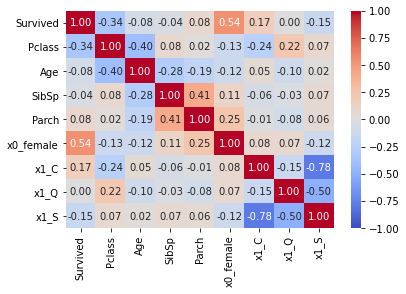

In [28]:
sns.heatmap(data.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

### Single function to uniformize a dataset

Let us gather the functions we have used to modify the `data` dataframe in a single function:

In [29]:
def prepare(df):
    df = delete_cabin(df)
    create_title(df)
    fill_age(df)
    fill_Embarked(df)
    df = drop_columns(df)
    df = to_cat(df)
    return df

We will not use it on the training data as they have already been prepared. 
But it will be used to prepare the test data.

## Choice of models

### What models to use? 

We want to solve a classification problem (with two classes: ‘survived’ or ‘did not survive’) using a supervised model (since we know which class corresponds to each training sample). 
Five models which are often very effective in this case are decision trees, random forests, support vector machines, k-nearest neighbours, and multi-layer perceptrons. 
We will thus choose these models in the following.

### Separation into training and test data

In [29]:
# set the random state to a fixed value, to make the experiment reproducible
random_state = 41

# fraction of the lines to be used for the test
fraction_test = 0.15

y_data = data['Survived']
x_data = data.drop(['Survived'], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=fraction_test, 
                                                    random_state=random_state)

### Some preliminary experiments

To get a feel for which problems may arise and how to resolve them, let us first train and test a few simple models with fixed parameters. 
Let us first extract validation data from the training data:

In [30]:
# fraction of the lines to be used as validation data
fraction_val = 0.15

x_train_noval, x_val, y_train_noval, y_val = train_test_split(x_train, y_train, 
                                                  test_size=fraction_val, 
                                                  random_state=random_state)

Let us then build and test a decision tree from the scikit-learn module with default parameters:

In [31]:
# generate the model
model_tree_1 = tree.DecisionTreeClassifier()

# fit the model on the train data
model_tree_1.fit(x_train_noval, y_train_noval)

# compute the accuracy
acc = (model_tree_1.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.7982456140350878


The accuracy is close to 80%. 
Given that we did not tune the hyperparameters at all, this looks like a good start. 

Let us now try with a random forest, also with default parameters:

In [32]:
# generate the model
model_forest_1 = RandomForestClassifier()

# fit the model on the train data
model_forest_1.fit(x_train_noval, y_train_noval)

# compute the accuracy
acc = (model_forest_1.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.7894736842105263


The accuracy is again close to 80%. 

With a support vector machine:

In [33]:
# generate the model
model_svm_1 = svm.SVC()

# fit the model on the train data
model_svm_1.fit(x_train_noval, y_train_noval)

# compute the accuracy
acc = (model_svm_1.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.7631578947368421


The accuracy is again close to 80%. 

With a k-nearest-veighbours classifier:

In [34]:
# generate the model
model_knn_1 = KNeighborsClassifier()

# fit the model on the train data
model_knn_1.fit(x_train_noval, y_train_noval)

# compute the accuracy
acc = (model_knn_1.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.7719298245614035


The accuracy is till close to 80%.

Finally, let us try with a multi-layer perceptron:

In [35]:
# generate the model
model_MLP_1 = MLPClassifier()

# fit the model on the train data
model_MLP_1.fit(x_train_noval, y_train_noval)

# compute the accuracy
acc = (model_MLP_1.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.7631578947368421


/home/florent/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


This model also has an accuracy close to 80%. 

It seems that all these models give similar results with the default parameters. 
Our two goals in the next sections will be:
* Optimize the choice of parameters for each model.
* Perform a more systematic study to see if differences emerge when looking more closely at the results from the models.

## Parameter optimization

We will test different parameters with k-fold cross-validation, using the function `cross_val_score` from scikit-learn. 
Let us define a wrapper function `kfold` calling the `cross_val_score` function and computing the averaged accuracy:

In [36]:
def kfold(model, cv=5): 
    scores = cross_val_score(model, x_train, y_train, cv=cv)
    return scores.mean()

To see how it works, let us try it on the above five models:

In [37]:
score_tree_1 = kfold(model_tree_1)
score_forest_1 = kfold(model_forest_1)
score_svm_1 = kfold(model_svm_1)
score_knn_1 = kfold(model_knn_1)
score_MLP_1 = kfold(model_MLP_1)
print('Tree accuracy: {}'.format(score_tree_1))
print('Forest accuracy: {}'.format(score_forest_1))
print('SVM accuracy: {}'.format(score_svm_1))
print('KNN accuracy: {}'.format(score_knn_1))
print('Perceptron accuracy: {}'.format(score_MLP_1))

/home/florent/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/florent/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Tree accuracy: 0.7701463924712444
Forest accuracy: 0.7978999651446497
Perceprton accuracy: 0.8256361101429069


The scores are (as expected from the previous results) close to 80%.

### Decision tree

Let us first try with the different options for the criterion and strategy used for each split:

In [38]:
options = [{'criterion': 'gini', 'splitter': 'best'},
           {'criterion': 'gini', 'splitter': 'random'},
           {'criterion': 'entropy', 'splitter': 'best'},
           {'criterion': 'entropy', 'splitter': 'random'}
          ]
for opt in options: 
    model = tree.DecisionTreeClassifier(**opt)
    print(kfold(model))

0.7767601951899616
0.778110840013942
0.7741111885674451
0.7754618333914256


These options do not seem to change the results much. 
Let us try some other options:

In [39]:
options = [{'max_features': 'sqrt'},
           {'max_features': 1},
           {'max_depth': 1},
           {'min_samples_split': 10},
          ]
for opt in options: 
    model = tree.DecisionTreeClassifier(**opt)
    print(kfold(model))

0.7847159288950853
0.7596200766817707
0.7767427675148134
0.8044963401882189


Forcing the tree to be very shallow seems to slightly reduce the accuracy. 
However, increasing the value of `min_sample_split` seems to give better results. 
Let us plot the evolution of the accuracy with this parameter:

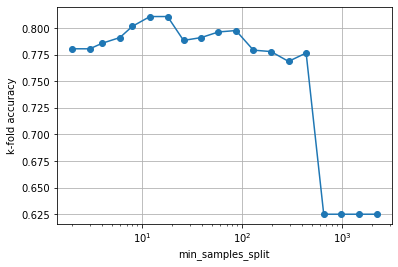

In [40]:
vals_sample_split = [1+int(1.5**i) for i in range(1,20)]

acc = []
for min_samples_split in vals_sample_split:
    model = tree.DecisionTreeClassifier(min_samples_split = min_samples_split)
    acc.append(kfold(model))
    
plt.plot(vals_sample_split, acc, '-o')
plt.xscale('log')
plt.xlabel('min_samples_split')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

The optimal value seems to be a bit above 10.

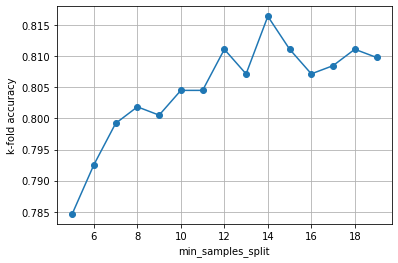

In [41]:
vals_sample_split = range(5,20)

acc = []
for min_samples_split in vals_sample_split:
    model = tree.DecisionTreeClassifier(min_samples_split = min_samples_split)
    acc.append(kfold(model))
    
plt.plot(vals_sample_split, acc, '-o')
plt.xlabel('min_samples_split')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

It seeems that a value of 14 gives the best results.

In [42]:
options = [{'max_leaf_nodes': 5},
           {'max_leaf_nodes': 20},
           {'max_leaf_nodes': 200},
           {'min_impurity_decrease': 0.},
           {'min_impurity_decrease': 0.5},
           {'min_impurity_decrease': 1.},
           {'ccp_alpha': 0.1},
           {'ccp_alpha': 0.5}
          ]
for opt in options: 
    model = tree.DecisionTreeClassifier(min_samples_split=14, **opt)
    print(kfold(model))

0.7873649355176019
0.8137504356918788
0.8124259323806203
0.8124259323806203
0.6248344370860928
0.6248344370860928
0.7767427675148134
0.6248344370860928


It seems that the only parameter for which the default value is not optimal is `min_samples_split`, which should be set to 14.

Let us train this model and test it on the test data:

In [43]:
model_tree_2 = tree.DecisionTreeClassifier(min_samples_split=14)
model_tree_2.fit(x_train, y_train)
acc = (model_tree_2.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.8771929824561403


The test accuracy is close to 0.88.

### Random forest

Let us now look for optimal parameters for the random forest classifier. 

In [44]:
options = [{},
           {'n_estimators': 1},
           {'n_estimators': 10},
           {'n_estimators': 50},
           {'n_estimators': 100},
           {'n_estimators': 200}
          ]
for opt in options: 
    model = RandomForestClassifier(min_samples_split=14, **opt)
    print(kfold(model))
    
options = [{'max_depth': 1},
           {'max_depth': 2},
           {'max_depth': 4},
           {'max_depth': 8},
           {'max_depth': 16},
           {'max_depth': 100},
           {'max_depth': 400},
          ]
for opt in options: 
    model = RandomForestClassifier(min_samples_split=14, **opt)
    print(kfold(model))
    
options = [{'bootstrap': False},
           {'bootstrap': True},
          ]
for opt in options: 
    model = RandomForestClassifier(min_samples_split=14, **opt)
    print(kfold(model))

0.8349163471592889
0.7767689090275357
0.8216974555594284
0.8336092715231788
0.8336005576856047
0.8336179853607529
0.6975252701289648
0.8058121296619032
0.8282851167654236
0.8296444754269781
0.8309689787382363
0.8349424886720112
0.8336092715231788
0.8217235970721506
0.8388985709306379


None of these parameters seem to improve results over the default value. 
Let us check that the optimal value of `min_sample_split` is the same as for decision trees:

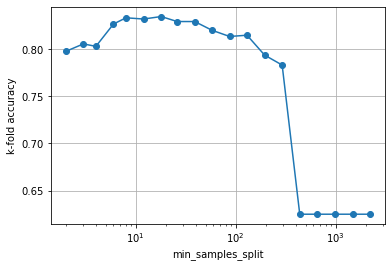

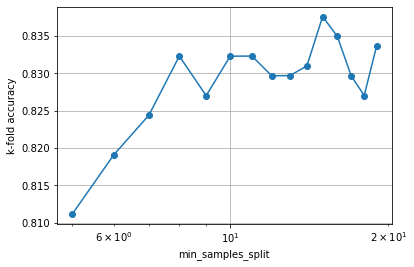

In [45]:
vals_sample_split = [1+int(1.5**i) for i in range(1,20)]

acc = []
for min_samples_split in vals_sample_split:
    model = RandomForestClassifier(min_samples_split = min_samples_split)
    acc.append(kfold(model))
    
plt.plot(vals_sample_split, acc, '-o')
plt.xscale('log')
plt.xlabel('min_samples_split')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

vals_sample_split = range(5,20)

acc = []
for min_samples_split in vals_sample_split:
    model = RandomForestClassifier(min_samples_split = min_samples_split)
    acc.append(kfold(model))
    
plt.plot(vals_sample_split, acc, '-o')
plt.xscale('log')
plt.xlabel('min_samples_split')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

The optimal value now seems to be 9. 

Let us train and test such a model:

In [46]:
model_forest_2 = RandomForestClassifier(min_samples_split=9)
model_forest_2.fit(x_train, y_train)
acc = (model_forest_2.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.9122807017543859


The accuracy is close to 0.91. 

### Support vector machine

Let us try with different kernel functions:

In [47]:
options = [{'kernel': 'linear'},
           {'kernel': 'rbf'},
           {'kernel': 'sigmoid'},
          ]
for opt in options: 
    model = svm.SVC(**opt)
    print(kfold(model))

0.7793830602997561
0.8190484489369118
0.6539212269083304


An rbf kernel seems to give the best result.

### K-nearest neighbours

Let us first try with the different weights and algorithms:

In [48]:
options = [{'weights': 'uniform', 'algorithm': 'auto'},
           {'weights': 'uniform', 'algorithm': 'ball_tree'},
           {'weights': 'uniform', 'algorithm': 'kd_tree'},
           {'weights': 'uniform', 'algorithm': 'brute'},
           {'weights': 'distance', 'algorithm': 'auto'},
           {'weights': 'distance', 'algorithm': 'ball_tree'},
           {'weights': 'distance', 'algorithm': 'kd_tree'},
           {'weights': 'distance', 'algorithm': 'brute'},
          ]
for opt in options: 
    model = KNeighborsClassifier(**opt)
    print(kfold(model))

0.8058818403624957
0.8058818403624957
0.8058818403624957
0.8032328337399791
0.7873649355176019
0.7873649355176019
0.7873649355176019
0.7820756361101429


The differences are quite small, although the fourth set of options seems to give slightly better results. 
Let us now look at the effects of the number of neighbours: 

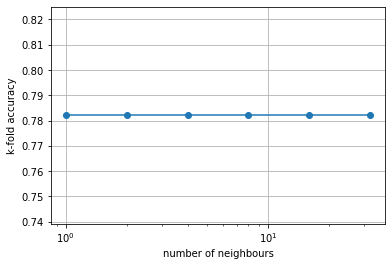

In [49]:
prev_options = {'weights': 'uniform', 'algorithm': 'brute'}

list_n_neighbours = [1, 2, 4, 8, 16, 32]

acc = []
for n in list_n_neighbours:
    mmodel = KNeighborsClassifier(n_neighbors=n, **prev_options)
    acc.append(kfold(model))
    
plt.plot(list_n_neighbours, acc, '-o')
plt.xscale('log')
plt.xlabel('number of neighbours')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

The number of neighbours does not seem to affect the accuracy at all. 
Let us now look at the `p` parameter:

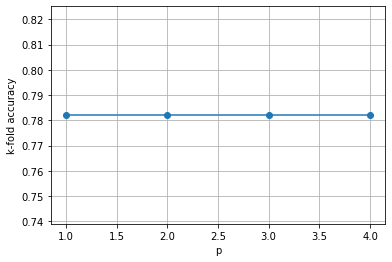

In [50]:
prev_options = {'weights': 'uniform', 'algorithm': 'brute'}

list_p = [1, 2, 3, 4]

acc = []
for p in list_p:
    mmodel = KNeighborsClassifier(p=p, **prev_options)
    acc.append(kfold(model))
    
plt.plot(list_p, acc, '-o')
plt.xlabel('p')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

Changing this parameter also does not seem to affect the results.

### Multi-layer perceptron

Finally, let us do some experiments with a multi-layer perceptron. 
We increase the value of `max_iter` (200 by default) to 400 to ensure the models converge.

We first look at different activation functions:

In [51]:
options = [{}, # default activation: ReLU 
           {'activation': 'identity'},
           {'activation': 'logistic'},
           {'activation': 'tanh'},
          ]
for opt in options: 
    model = MLPClassifier(max_iter=400, **opt)
    print(kfold(model))

0.8071453468107354
0.8071540606483095
0.8045573370512373
0.8124085047054722


On average, the default activation function seems to work as well qs the others. 

Let us look at the solver (we increase `max_iter` to 10,000 to ensure the model with the lbfgs solver converges):

In [52]:
options = [{}, # default activation: adam
           {'solver': 'lbfgs'},
           {'solver': 'sgd'},
          ]
for opt in options: 
    model = MLPClassifier(max_iter=10000, **opt)
    print(kfold(model))

0.8151010805158592
0.7820756361101429
0.8111188567445102


The default and sgd solvers seem to perform best.

Let us now look at the size and number of hidden layers. 
We first try with only one hidden layer:

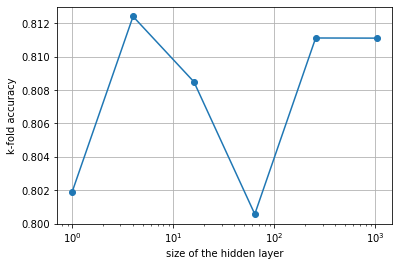

In [53]:
size_hl = [1, 4, 16, 64, 256, 1024]

acc = []
for s in size_hl:
    mmodel = MLPClassifier(max_iter=400, 
                           hidden_layer_sizes=(s,))
    acc.append(kfold(model))
    
plt.plot(size_hl, acc, '-o')
plt.xscale('log')
plt.xlabel('size of the hidden layer')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

The size of the hidden layer does not seem to affect the results much. 
In the following, we will use hidden layers of size 10. 
Let us now look at the effect of the number of hidden layers:

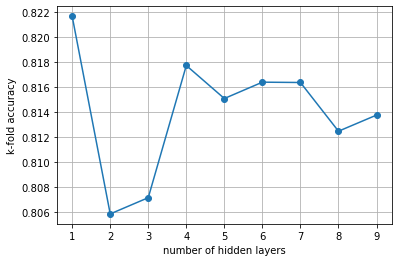

In [54]:
n_hl = range(1,10)

acc = []
for n in n_hl:
    mmodel = MLPClassifier(max_iter=400, 
                           hidden_layer_sizes=[10]*n)
    acc.append(kfold(model))
    
plt.plot(n_hl, acc, '-o')
plt.xlabel('number of hidden layers')
plt.ylabel('k-fold accuracy')
plt.grid()
plt.show()

There is no clear advantage in using more than one hidden layer. 

Let us now try with the three strategies for the learning rate:

In [55]:
options = [{}, # default strategy: constant
           {'learning_rate': 'invscaling'},
           {'learning_rate': 'adaptive'},
          ]
for opt in options: 
    model = MLPClassifier(max_iter=1000, 
                          hidden_layer_sizes=(10,), **opt)
    print(kfold(model))

0.815074939003137
0.8190048797490415
0.8058469850121994


There is no clear difference between these results. 
Try changing the value of the learning rate:

In [56]:
options = [{'learning_rate_init': 0.1},
           {'learning_rate_init': 0.01},
           {'learning_rate_init': 0.001},
           {'learning_rate_init': 0.0001},
          ]
for opt in options: 
    model = MLPClassifier(max_iter=10000, 
                          hidden_layer_sizes=(10,), **opt)
    print(kfold(model))

0.795233530846985
0.8110840013942141
0.8045224817009411
0.7820494945974208


The default value (0.001) seems to give the best results. 

Finally, let is try changing the three parameters `beta_1`, `beta_2`, and `epsilon` of the Adam solver:

In [57]:
options = [{'beta_1': 0.99},
           {'beta_1': 0.8},
           {'beta_1': 0.7},
           {'beta_1': 0.6},
           {'beta_2': 0.9999},
           {'beta_2': 0.99},
           {'epsilon': 10**(-9)},
           {'epsilon': 10**(-7)},
           {'epsilon': 10**(-6)},
          ]
for opt in options: 
    model = MLPClassifier(max_iter=1000, 
                          hidden_layer_sizes=(10,), **opt)
    print(kfold(model))

0.8084524224468457
0.8084698501219938
0.8124607877309167
0.8124259323806203
0.8084698501219938
0.811084001394214
0.8005576856047405
0.8044963401882189
0.8071540606483095


Running this cell several times, there is marginal evidence that the smaller values of `beta_1` give better results. 
(But the results for the values 0.7 and 0.6 are not reaslly statistically distinguishable.)

Let us train a model on the whole training set and evaluate it:

In [58]:
model_MLP_2 = MLPClassifier(max_iter=1000, hidden_layer_sizes=(10,), beta_1=0.6)
model_MLP_2.fit(x_train, y_train)
acc = (model_MLP_2.predict(x_val) == y_val).mean()
print('Accuracy: {}'.format(acc))

Accuracy: 0.8157894736842105


The accuracy is only close to 0.84, suggesting that this model performs less well that a decision tree or forest. 
However, since the validation set is rather small, this difference may not be statistically significant.

## Training on the full available dataset

### Optimizing the choice of models

In this section, we make experiments to determine which models should be used or not. 
We will always use an odd number of different models. 
If more than one of them is used and if they give different predictions, the final prediction will be determined by majority rule.

The function `try_models` below tests the average accuracy of an ensemble of models:

In [59]:
def try_models(models_to_try, n_experiments=20, fraction_val=0.15):
    
    y_data = data['Survived']
    x_data = data.drop(['Survived'], 1)
    
    accs = []
    
    for _ in range(n_experiments):
    
        models = deepcopy(models_to_try)
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=fraction_val)


        # train the models
        for model in models:
            model.fit(x_train, y_train)

        # predictions
        predictions = [
            model.predict(x_val)
            for model in models
        ]

        prediction = sum(prediction for prediction in predictions) > len(models) // 2

        accs.append((prediction == y_val).sum() / len(y_val))
        
    return (np.mean(accs), np.std(accs))

Let us first try with each model separately:

In [60]:
models = [
    tree.DecisionTreeClassifier(min_samples_split=14),
    RandomForestClassifier(min_samples_split=9),
    svm.SVC(kernel='rbf'),
    KNeighborsClassifier(weights='uniform', algorithm='brute'),
    MLPClassifier(max_iter=1000, hidden_layer_sizes=(10,), beta_1=0.6),
]

for model in models:
    res = try_models([model])
    print('{} ± {}'.format(res[0],res[1]))

0.8842105263157893 ± 0.02229520180199794
0.893859649122807 ± 0.013841871787771486
0.7824561403508772 ± 0.006564311204866584
0.8425438596491228 ± 0.015562451753693128
0.8109649122807017 ± 0.016049275845203513


The support vector machine seem to have the lowest accuracy. 
Let us try removing it and the k-nearest neighbours model:

In [61]:
res = try_models([
    tree.DecisionTreeClassifier(min_samples_split=14),
    RandomForestClassifier(min_samples_split=9),
    MLPClassifier(max_iter=1000, hidden_layer_sizes=(10,), beta_1=0.6),
])
print('{} ± {}'.format(res[0],res[1]))

0.8728070175438596 ± 0.01581382138361399


The results are about as good as those obtained using a classification tree or random forest alone.
Let us try adding the other two models:

In [62]:
res = try_models([
    tree.DecisionTreeClassifier(min_samples_split=14),
    RandomForestClassifier(min_samples_split=9),
    KNeighborsClassifier(weights='uniform', algorithm='brute'),
    svm.SVC(kernel='rbf'),
    MLPClassifier(max_iter=1000, hidden_layer_sizes=(10,), beta_1=0.6),
])
print('{} ± {}'.format(res[0],res[1]))

0.8543859649122807 ± 0.014252698955501695


The results get a bit worse. 
Let us try removing the neural network:

In [63]:
res = try_models([
    tree.DecisionTreeClassifier(min_samples_split=14),
    RandomForestClassifier(min_samples_split=9),
    KNeighborsClassifier(weights='uniform', algorithm='brute'),
])
print('{} ± {}'.format(res[0],res[1]))

0.8969298245614036 ± 0.017295389608009082


With only the two best-performing models (we add a second random tree to have an odd number of models):

In [64]:
res = try_models([
    tree.DecisionTreeClassifier(min_samples_split=14),
    tree.DecisionTreeClassifier(min_samples_split=14),
    RandomForestClassifier(min_samples_split=9),
])
print('{} ± {}'.format(res[0],res[1]))

0.8855263157894736 ± 0.016287232129497484


This seems to give similar results. 
Let us try with three classification trees:

In [65]:
n_trees = 3
res = try_models([
    tree.DecisionTreeClassifier(min_samples_split=14)
    for _ in range(n_trees)
])
print('{} ± {}'.format(res[0],res[1]))

0.8793859649122806 ± 0.017950335026036084


The results are similar. 
Since a random forest is less prone to overtraining, let us use it for our submission:

In [66]:
# define the models
models = [
    RandomForestClassifier(min_samples_split=9)
]  

# train the models
for model in models:
    model.fit(x_data, y_data)

# load the test data
name_test_file = '../Data/Kaggle_Titanic/test.csv'
test_data = prepare(pd.read_csv(name_test_file))

# predictions of each model
predictions = [
    model.predict(test_data)
    for model in models
]

# final prediction
prediction = sum(prediction for prediction in predictions) > len(models) // 2

### Save the predictions

Finally, let us save the predictions in the format required by Kaggle:

In [67]:
submission = pd.DataFrame([pd.read_csv(name_test_file)['PassengerId'], prediction]).T
submission.columns = ['PassengerId','Survived']
submission.to_csv('../Data_cleaned/Kaggle_Titanic/submission1.csv', index=False)

### Alternative prediction

Let us make an alternative prediction based on the gender and Pclass only. 
The motivation for this is that
* `Pclass` is the numerical column with the highest absolute correlation with the survival probability in the training set,
* the `Sex` column is expected to be important too because of the ‘women and children first’ policy.

We also make another change concerning the `Pclass` column. 
While its values are numerical, there is *a priori* no reason why the numerical relation between them and the survival probability be a simple function. 
We will thus split it using one-hot encoding, which may help the model to learn more complicate relations.

In [30]:
# load the test data
name_test_file = '../Data/Kaggle_Titanic/test.csv'
test_data = prepare(pd.read_csv(name_test_file))

# convert the Pclass column to one-hot format: for the train data...
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(data[['Pclass']])
one_hot_cols = pd.DataFrame(ohe.transform(data[['Pclass']]), columns=ohe.get_feature_names())
data = pd.concat([data, one_hot_cols], axis=1)
data = data.drop(['Pclass','x0_1'], axis=1)

# ... and for the test data
one_hot_cols = pd.DataFrame(ohe.transform(test_data[['Pclass']]), columns=ohe.get_feature_names())
test_data = pd.concat([test_data, one_hot_cols], axis=1)
test_data = test_data.drop(['Pclass','x0_1'], axis=1)[['x0_female','x0_2','x0_3']]

# define the models
models = [
    RandomForestClassifier(min_samples_split=9)
]  

# train the models
for model in models:
    model.fit(data[['x0_female','x0_2','x0_3']], data['Survived'])

# predictions of each model
predictions = [
    model.predict(test_data)
    for model in models
]

# final prediction
prediction = sum(prediction for prediction in predictions) > len(models) // 2

submission = pd.DataFrame([pd.read_csv(name_test_file)['PassengerId'], prediction]).T
submission.columns = ['PassengerId','Survived']
submission.to_csv('../Data_cleaned/Kaggle_Titanic/submission2.csv', index=False)

## Results and discussion

## Possible improvements